<a href="https://colab.research.google.com/github/pavlo-seimskyi/filler-sound-detector/blob/train-first-model/3-train-first-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torch -U
!pip install torchaudio -U
!pip3 install pickle5
!git clone --recursive https://github.com/Microsoft/LightGBM
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

In [2]:
import os
import shutil
import pickle5 as pickle
import logging

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from torchaudio import functional as F, transforms as T
import torch

import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
TEXT_COLOR = '#313131'
# Plotly colors
LINE_COLORS = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

sns.set(
    style='darkgrid', 
    rc={
        'figure.figsize':(6,4),
        'figure.dpi': 100,
        'figure.facecolor': 'w',
        'legend.facecolor': 'w',
        'text.color': TEXT_COLOR,
        'font.family': 'Microsoft Sans Serif',
        'axes.labelcolor': TEXT_COLOR,
        'xtick.color': TEXT_COLOR,
        'ytick.color': TEXT_COLOR
    }
)

sns.set_palette(sns.color_palette(LINE_COLORS))

In [5]:
# What GPU am I using?
torch.cuda.get_device_name(0)

'Tesla T4'

In [6]:
CUTOFF_THRES = 0.8

# Copy processed data from gDrive

In [7]:
# Source
GDRIVE_FOLDER = "drive/MyDrive/data-science/filler-sound-detector/data"
FEATURES_SRC_FOLDER = os.path.join(GDRIVE_FOLDER, "features")
TARGETS_SRC_FOLDER = os.path.join(GDRIVE_FOLDER, "targets")

# Destination
FEATURES_PATH = "data/features"
TARGETS_PATH = "data/targets"

In [8]:
feature_files = os.listdir(FEATURES_SRC_FOLDER)
target_files = os.listdir(TARGETS_SRC_FOLDER)

In [9]:
os.makedirs(FEATURES_PATH, exist_ok=True)
os.makedirs(TARGETS_PATH, exist_ok=True)

In [10]:
%%time
for features, targets in zip(feature_files, target_files):
    features_src = os.path.join(FEATURES_SRC_FOLDER, features)
    features_dst = os.path.join(FEATURES_PATH, features)

    targets_src = os.path.join(TARGETS_SRC_FOLDER, targets)
    targets_dst = os.path.join(TARGETS_PATH, targets)
    shutil.copy(src=features_src, dst=features_dst)
    shutil.copy(src=targets_src, dst=targets_dst)

---

# Read data

In [11]:
def read_pickle(path):
    with open(path, 'rb') as handle:
        return pickle.load(handle)

In [12]:
def convert_target_to_binary(y, threshold):
    out = y.clone()
    out[out >= threshold] = 1
    out[out < threshold] = 0
    return out

In [13]:
%%time
x = torch.tensor([])
y = torch.tensor([])

for speaker_filename in os.listdir(FEATURES_PATH):
    current_x = read_pickle(f"{FEATURES_PATH}/{speaker_filename}")
    current_y = read_pickle(f"{TARGETS_PATH}/{speaker_filename}")

    x = torch.concat((x, current_x), dim=1)
    y = torch.concat((y, current_y), dim=0)

---

# Train model

## Prepare data for training

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x.transpose(0, 1),
    convert_target_to_binary(y, threshold=CUTOFF_THRES), 
    test_size=0.33,
    shuffle=False,
)

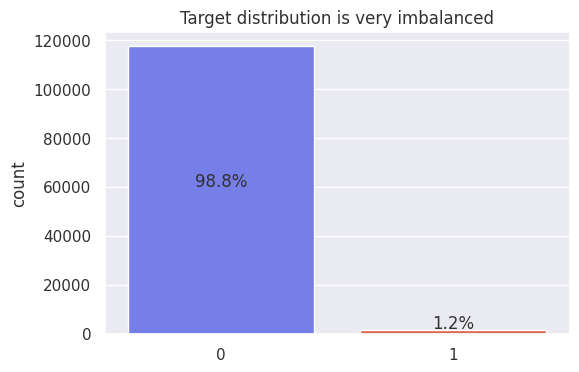

In [29]:
fig,ax = plt.subplots()
sns.countplot(x=y_valid.numpy().astype(int), ax=ax)

# show the count in %
for p in ax.patches:
    h_, w_, x_ = p.get_height(), p.get_width(), p.get_x()
    xy_ = (x_ + w_ / 2., h_ / 2)
    pct = 100 * h_ / y_valid.shape[0]
    text = f'{pct:0.1f}%'
    ax.annotate(s=text, xy=xy_, ha='center', va='bottom')
    
plt.title("Target distribution is very imbalanced")
plt.show()

### Define evaluation functions

In [30]:
def evaluate(y_test, y_pred_proba, threshold):
    print_metrics(y_test, y_pred_proba, threshold)
    y_pred = convert_target_to_binary(y_pred_proba, threshold)

    y_test = y_test.cpu().numpy()
    y_pred_proba = y_pred_proba.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    plt.tight_layout(h_pad=1, w_pad=9)
    plot_confusion_matrix(y_test, y_pred, ax=axs[0])
    plot_precision_recall_curve(y_test, y_pred_proba, threshold, ax=axs[1])

In [31]:
def print_metrics(y_test, y_pred_proba, threshold):
    y_pred = convert_target_to_binary(y_pred_proba, threshold=threshold)

    metrics = {
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "avg_precision_score": average_precision_score(y_test, y_pred_proba)
    }

    print(", ".join([f"{name}: {round(value, 3)}" for name, value in metrics.items()]))

In [32]:
def plot_precision_recall_curve(y_test, y_pred_proba, threshold, ax):
    """Plot the curve with a marker pointing to the current cutoff threshold.
    :param y_test: true target variable
    :param y_pred_proba: prediction probabilities for the positive class (0.0 to 1.0)
    :param threshold: cutoff point to determine the final prediction
    :param ax: matplotlib.plt axis
    :return: None
    """
    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, ax=ax)
    ax.set_title("Precision-recall curve")
    y_pred = (y_pred_proba >= threshold).astype(float)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    ax.plot(
        recall,
        precision,
        marker="x",
        color="r",
        markersize=15,
        label="chosen threshold",
    )
    ax.legend()

In [33]:
def plot_confusion_matrix(y_test, y_pred, ax):
  """
  Plot a confusion matrix on axis.
  :param y_test: true target variable
  :param y_pred: predictions
  :param ax: matplotlib.plt axis
  :return: None
  """
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
  ax.grid(False)
  ax.set_title("Confusion matrix")

## Train the baseline

Train a `LightGBM` model on the obtained features to see if it can pick anything from them.

In [34]:
x_train_numpy  = x_train.numpy()
x_valid_numpy = x_valid.numpy()
y_train_numpy = y_train.numpy().astype(int)
y_valid_numpy = y_valid.numpy().astype(int)

In [35]:
labels, counts = np.unique(y_train_numpy.astype(int), return_counts=True)
class_weights = {k: v for k, v in zip(np.flipud(labels), counts)}

Start training with some reasonable default parameters.

In [39]:
lgb_model = lgb.LGBMClassifier(
    is_unbalance=True,
    # scale_pos_weight=class_weights[1] / class_weights[0],
    feature_fraction=0.7,
    reg_alpha=0.7,
    reg_lambda=0.7,
    n_estimators=1000,
    random_state=42,
)

In [40]:
lgb_model = lgb_model.fit(
    X=x_train_numpy,
    y=y_train_numpy,
    eval_set=[(x_valid_numpy, y_valid_numpy), (x_train_numpy, y_train_numpy)],
    eval_names=["validation set", "training set"],
    eval_metric="f1",
    callbacks=[lgb.early_stopping(10)],
)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Number of positive: 2781, number of negative: 238676
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 241457, number of used features: 40
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011518 -> initscore=-4.452296
[LightGBM] [Info] Start training from score -4.452296
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[680]	training set's binary_loglo

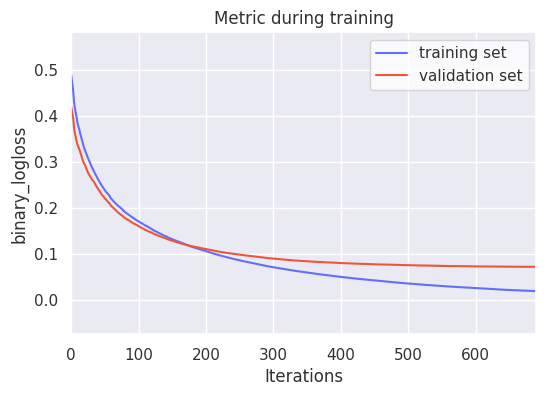

In [41]:
lgb.plot_metric(lgb_model);

In [42]:
y_pred_proba = lgb_model.predict_proba(x_valid_numpy)[:, 1]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


f1: 0.114, precision: 0.308, recall: 0.07, avg_precision_score: 0.098


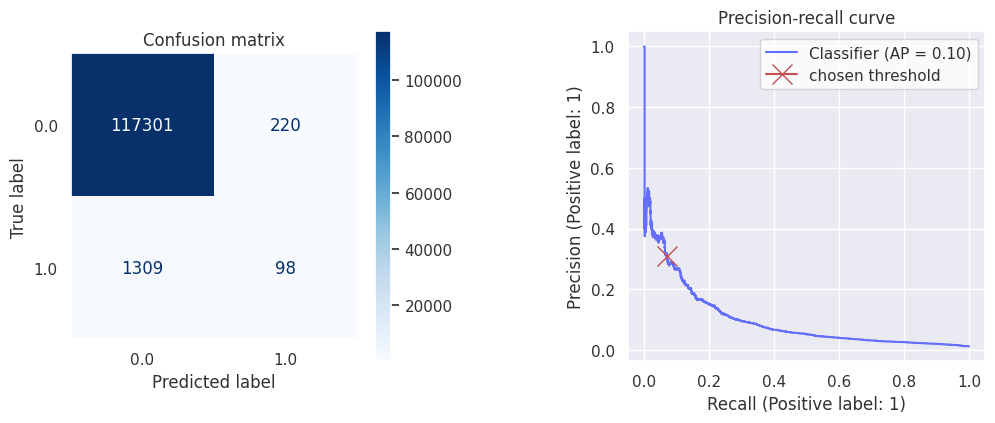

In [43]:
evaluate(y_valid, torch.Tensor(y_pred_proba), threshold=CUTOFF_THRES)

---

Perform grid-search

In [ ]:
# lgb_model = lgb.LGBMClassifier(
#     class_weight=class_weights,
#     # is_unbalance=True,
#     # scale_pos_weight=scale_pos_weight,
#     random_state=42,
# )

In [ ]:
# param_grid = {
#     "max_depth" : [-1, 4, 8],  # How deep a tree can go. More -> More complexity
#     "num_leaves" : [2, 8, 31],  # Each new tree will have max this amount of leaf nodes. More -> More complexity
#     "feature_fraction": [0.5, 0.8],  # Subset of features to select on each new iteration
#     "reg_alpha": [0, 0.3, 0.7],
#     "reg_lambda": [0, 0.3, 0.7],
#     "learning_rate": [0.03, 0.1, 0.9],
#     "num_estimators": [500],
# }

In [ ]:
# grid_model = GridSearchCV(lgb_model, param_grid, scoring="f1", cv=3, verbose=-1)

In [ ]:
# grid_model.fit(x_train_numpy, y_train_numpy, verbose=-1)

---

## Train the good model

### Define the architecture

In [ ]:
logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.DEBUG)

In [ ]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_classes, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.optimizer = None
        self.logger = None
        self.in_layer = torch.nn.Linear(n_features, n_hidden)
        self.mid_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_classes)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        out = self.in_layer(x)
        out = self.relu(out)
        out = self.mid_layer(out)
        out = self.relu(out)
        out = self.out_layer(out)
        return self.softmax(out)

    # def set_optimizer(self, learning_rate=1e-4):
    #     self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    # def fit(self, x, y, n_epochs):
    #     self.set_optimizer() if not self.optimizer
    #     dl = self.build_dataloader(x, y)
    #     self.train()
    #     for epoch in range(n_epochs):
    #         for batch in dl:
    #             self.training_step(batch)

    # def training_step(self, batch):
    #     x, y_true = batch
    #     x = x.cuda(0)
    #     y_pred = self(x)
    #     loss = self.loss_fn(y_pred, y_true)
    #     self.log("train loss", loss.item())
    #     loss.backward()
    #     self.optimizer.step()
    #     self.optimizer.zero_grad()

    # def validation_step(self, batch):
    #     self.eval()
    #     with torch.no_grad():
    #         x, y_true = batch
    #         x = x.cuda(0)
    #         y_pred = self(x)
    #         loss = self.loss_fn(y_pred, y_true)
    #         self.log(f"valid loss: {loss.item()}")

    # def build_dataloader(self, x, y=None):
    #     pass

    # def log(self, msg, level="debug"):
    #     if self.logger is None: 
    #         self.set_logger()
    #     logger.log(level, msg)

    # def set_logger(self):
    #     logging.basicConfig(
    #         format='[%(asctime)s]–[%(levelname)s]–[%(message)s]',
    #         datefmt='%Y-%m-%d %H:%M:%S',
    #         level=logging.INFO
    #     )
    #     self.logger = logging.getLogger(__name__)
    #     self.logger.addHandler(logging.StreamHandler())
    #     self.logger.setLevel(logging.DEBUG)

In [ ]:
N_FEATURES = x_train.shape[1]
N_HIDDEN = 128

In [ ]:
nn_model = MultiLayerPerceptron(
    n_features=N_FEATURES, 
    n_hidden=N_HIDDEN, 
    n_classes=2,
)

---

### Train

Train using [this guide](https://github.com/christianversloot/machine-learning-articles/blob/main/creating-a-multilayer-perceptron-with-pytorch-and-lightning.md).

In [ ]:
# continue here

---